# Installing the required libraries

In [1]:
# !pip install torch
# !pip install git+https://github.com/openai/CLIP.git
# !pip install matplotlib

# Let's run a few experiments to get some functionalities up and running and we'll later decide which of these would be the final solution.

## Here's our sample dataset

In [2]:
import json
data = json.loads(open('data/temp_data.json').read())
data

[{'item_name': 'Stainless Steel Cutlery Set',
  'category': 'Cutlery',
  'color': 'Stainless Steel',
  'description': 'A set of 12 stainless steel cutlery pieces, including forks, knives, spoons, and a salad server. Dishwasher safe.',
  'image_url': 'https://shared-data-7374.s3.amazonaws.com/temp/1.jpeg'},
 {'item_name': 'Ceramic Dinner Plates',
  'category': 'Dinnerware',
  'color': 'White',
  'description': 'A set of 4 ceramic dinner plates with a white glaze and a delicate pattern. Dishwasher and microwave safe.',
  'image_url': 'https://shared-data-7374.s3.amazonaws.com/temp/2.jpeg'},
 {'item_name': 'Glass Wine Glasses',
  'category': 'Drinkware',
  'color': 'Clear',
  'description': 'A set of 6 glass wine glasses with a stem and a narrow bowl. Dishwasher safe.',
  'image_url': 'https://shared-data-7374.s3.amazonaws.com/temp/3.jpeg'},
 {'item_name': 'Stainless Steel Water Bottles',
  'category': 'Drinkware',
  'color': 'Stainless Steel',
  'description': 'A set of 2 stainless steel

## Experiment 1 : Given an image - get me N similar images from the dataset

### Step 1 : Preparing dataset

In [3]:
import json
import requests
import torch
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the JSON file
with open('data/temp_data.json') as f:
    data = json.load(f)

# Extract the image URLs
image_urls = [item['image_url'] for item in data]

# Load the CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Generate embeddings for each image
embeddings = []
for url in image_urls:
    image = Image.open(requests.get(url, stream=True).raw)
    image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(image)
    embeddings.append(embedding.cpu().numpy())

# Convert the embeddings to a numpy array
embeddings = np.array(embeddings)

# Print the dimensions of the embeddings
print("Embeddings shape:", embeddings.shape)



Embeddings shape: (10, 1, 512)


### Step 2 : Creating Functionality to query the dataset

In [4]:
# Define the function to retrieve similar images
def get_similar_images(image_url, n=5):
    # Generate the embedding for the input image
    # image = Image.open(requests.get(image_url, stream=True).raw)
    image = Image.open(image_url)
    image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(image)
    embedding = embedding.cpu().numpy()

    # Calculate the cosine similarity between the input embedding and all other embeddings
    similarities = np.dot(embeddings, embedding.T).flatten()

    # Retrieve the indices of the N most similar images
    indices = np.argsort(similarities)[-n:][::-1]

    # Retrieve the similar image URLs
    similar_urls = [image_urls[i] for i in indices]

    return similar_urls

# Define the function to display the input image and the N most similar images
def display_images(input_url, similar_urls):
    # Display the input image
    input_image = Image.open(input_url)
    plt.subplot(1, len(similar_urls) + 1, 1)
    plt.imshow(input_image)
    plt.title("Input Image")
    plt.axis("off")

    # Display the N most similar images
    for i, url in enumerate(similar_urls):
        image = Image.open(requests.get(url, stream=True).raw)
        plt.subplot(1, len(similar_urls) + 1, i + 2)
        plt.imshow(image)
        plt.title(f"Similar Image {i + 1}")
        plt.axis("off")

    plt.show()


### Testing the functionality

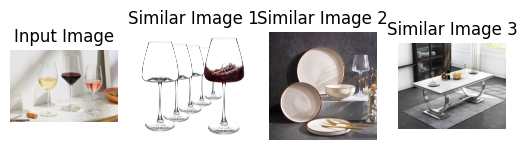

In [5]:

input_url = 'data/f2.jpeg'
similar_urls = get_similar_images(input_url, n=3)
display_images(input_url, similar_urls)

## Experiment 2 : Given a text, get me N similar images from the dataset

### Step 1 : Preparing dataset

In [10]:
import matplotlib.pyplot as plt
import json
import requests
import torch
import clip
from PIL import Image

# Load the JSON file
with open('data/temp_data.json') as f:
    data = json.load(f)

# Extract the image URLs and descriptions
image_urls = [item['image_url'] for item in data]
descriptions = [item['description'] for item in data]

# Load the CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Generate embeddings for each image
image_embeddings = []
for url in image_urls:
    image = Image.open(requests.get(url, stream=True).raw)
    image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(image)
    image_embeddings.append(embedding.cpu().numpy())

# Convert the embeddings to a numpy array
image_embeddings = np.array(image_embeddings)

# Generate embeddings for each description
text_embeddings = []
for description in descriptions:
    text = clip.tokenize([description]).to(device)
    with torch.no_grad():
        embedding = model.encode_text(text)
    text_embeddings.append(embedding.cpu().numpy())

# Convert the embeddings to a numpy array
text_embeddings = np.array(text_embeddings)

### Step 2 : Creating Functionality to query the dataset

In [11]:
# Define the function to retrieve similar images based on a text query
def get_similar_images(query, n=5, category="all"):
    # Generate the embedding for the query
    text = clip.tokenize([query]).to(device)
    with torch.no_grad():
        embedding = model.encode_text(text)
    embedding = embedding.cpu().numpy()

    # Calculate the cosine similarity between the query embedding and all image embeddings
    similarities = np.dot(image_embeddings, embedding.T).flatten()

    # Retrieve the indices of the N most similar images
    indices = np.argsort(similarities)[-n:][::-1]

    # Retrieve the similar image URLs
    similar_urls = [image_urls[i] for i in indices]

    return similar_urls

# Define the function to display the input image and the N most similar images
def display_images(input_url, similar_urls):
    # Display the input image
    input_image = Image.open(requests.get(input_url, stream=True).raw)
    plt.subplot(1, len(similar_urls) + 1, 1)
    plt.imshow(input_image)
    plt.title("Input Image")
    plt.axis("off")

    # Display the N most similar images
    for i, url in enumerate(similar_urls):
        image = Image.open(requests.get(url, stream=True).raw)
        plt.subplot(1, len(similar_urls) + 1, i + 2)
        plt.imshow(image)
        plt.title(f"Similar Image {i + 1}")
        plt.axis("off")

    plt.show()

### Step 3 : Testing the functionality

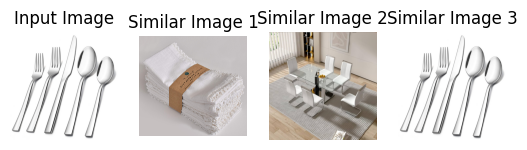

In [ ]:
# Perform a text-based image retrieval and display the results
query = "napkins"
similar_urls = get_similar_images(query, n=3)
display_images(image_urls[0], similar_urls)

# Okay, now let's get started with the Final Flow

### Initial Setup

In [12]:
from PIL import Image
from openai import OpenAI
import numpy as np
import json
import requests
import logging
import matplotlib.pyplot as plt
import json
import requests
import torch
from PIL import Image
import clip
import requests
from PIL import Image
from io import BytesIO

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

client = OpenAI(api_key="ENTER API KEY")

# Let's create the text and image embeddings

# Load the JSON file
with open('data/temp_data.json') as f:
    data = json.load(f)

# Extract the image URLs and descriptions
image_urls = [item['image_url'] for item in data]
descriptions = [item['description'] for item in data]

# Load the CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Generate embeddings for each image
image_embeddings = []
for url in image_urls:
    image = Image.open(requests.get(url, stream=True).raw)
    image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(image)
    image_embeddings.append(embedding.cpu().numpy())

# Convert the embeddings to a numpy array
image_embeddings = np.array(image_embeddings)

# Generate embeddings for each description
text_embeddings = []
for description in descriptions:
    text = clip.tokenize([description]).to(device)
    with torch.no_grad():
        embedding = model.encode_text(text)
    text_embeddings.append(embedding.cpu().numpy())

# Convert the embeddings to a numpy array
text_embeddings = np.array(text_embeddings)

### Utility Functions

In [13]:
# Define the function to display the input image and the N most similar images
def display_images(input_url, similar_urls):
    # Display the input image
    input_image = Image.open(input_url)
    plt.subplot(1, len(similar_urls) + 1, 1)
    plt.imshow(input_image)
    plt.title("Input Image")
    plt.axis("off")

    # Display the N most similar images
    for i, url in enumerate(similar_urls):
        image = Image.open(requests.get(url, stream=True).raw)
        plt.subplot(1, len(similar_urls) + 1, i + 2)
        plt.imshow(image)
        plt.title(f"Similar Image {i + 1}")
        plt.axis("off")

    plt.show()

### Prompt Functionality

In [14]:
def normal_chat(prompt):
    logger.info(f"Normal chat detected. Responding with the same prompt.")
    # Later change this to a proper response
    return prompt

def extract_n_category_prompt(prompt):
    logger.info(f"Extracting details from prompt: {prompt}")
    prompt=f"Extract the number of similar images (N) and the category from the following prompt: '{prompt}'. If not sure about the category, default to 'all'. If not sure about the number of images, default to 3. Return response in strictly json format with keys 'N' and 'category'.",
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": f"{prompt}"}
        ]
    )
    return response.choices[0].message.content

def extract_details_from_prompt(prompt):
    logger.info(f"Extracting details from prompt: {prompt}")
    try:
        details = extract_n_category_prompt(prompt)
        logger.info(f"Received response from OpenAI: {details}")
        details_json = json.loads(details)
        N = int(details_json.get("N", 3))
        category = details_json.get("category", "all")
    except json.JSONDecodeError as e:
        logger.error(f"JSON decode error: {e}")
        N, category = 3, "all"
    except Exception as e:
        logger.error(f"Error in extracting details: {e}")
        N, category = 3, "all"
    logger.info(f"Extracted details - N: {N}, category: {category}")
    return N, category


def extract_intent_from_promptO(prompt):
    logger.info(f"Extracting intent from prompt: {prompt}")
    prompt=f"Extract the number of similar images (N) and the category from the following prompt: '{prompt}'. If not sure about the category, default to 'all'.Return response in strictly json format with keys 'N' and 'category'."
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": f"{prompt}"}
        ]
    )
    return response.choices[0].message.content


intents = {
    "normal_chat": ["chat", "talk", "hello", "hi", "hey"],
    "show_similar": ["show similar", "similar images", "like these", "more like"],
    "show_complementary": ["complementary", "go well with", "match this", "pair with"]
}

def check_intent_with_keywords(user_input):
    user_input = user_input.lower()
    
    for intent, keywords in intents.items():
        for keyword in keywords:
            if keyword in user_input:
                return intent
    
    return None

def check_intent_with_gpt(user_input):
    prompt = (
        "You are an AI assistant. A user is interacting with a chatbot. "
        "Based on the user's input, identify if the user is engaging in normal chat, "
        "asking to show similar images, or asking for complementary items.\n\n"
        "User input: " + user_input + "\n\n"
        "Identify the intent as one of the following: normal_chat, show_similar, show_complementary. "
        "Respond with the intent in the following JSON format: {\"intent\": \"<intent>\"}"
    )
    logger.info(f"Extracting intent from prompt: {prompt}")
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[  
            {"role": "user", "content": f"{prompt}"}
        ]
    )
    logger.info(f"Received response from OpenAI: {response.choices[0].message.content}")
    intent = response.choices[0].message.content
    intent_json = json.loads(intent)
    intent = intent_json.get("intent")
    return intent


def determine_intent(user_input):
    # First layer: Keyword matching
    intent = check_intent_with_keywords(user_input)
    logger.info(f"Intent from keyword matching: {intent}")
    
    # Second layer: If no intent found, use GPT-3.5
    if intent is None:
        intent = check_intent_with_gpt(user_input)
        intent_json = json.loads(intent)
    
    return intent

### Getting Similar and Complementary Images

In [35]:
import requests
from PIL import Image
from io import BytesIO
import json
import base64

def analyze_image(image_url, input_prompt, category, n=3):
    # Read the image from the URL
    image = Image.open(image_url)

    # Convert the image to base64
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    image_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")

    # Generate the prompt for the GPT-4 API
    prompt = f"""Given an image and a prompt, analyze the image and the prompt and generate a JSON output with the following fields: "items", "category", and "style".
                 The prompt is: "{input_prompt}".
                 Use your understanding of home decor, style, and preferences to provide accurate and relevant suggestions for how to complete the room.
                 The items field should be a list of {n} items that would go well with the item in the picture and the prompt. Each item should represent a title of an item that contains the style, color, and category of the item.
                 The category should be set to "{category}".
                 You have to choose between the styles in this list: [Modern, Traditional, Contemporary, Rustic, Eclectic, Minimalist, Bohemian, Industrial, Vintage, Farmhouse, Scandinavian, Mediterranean, Asian, Coastal, Tropical].
                 Do not include the description of the item in the picture. Do not include the ```json ``` tag in the output.

                 Example Input: An image representing a wooden dinner table and the prompt "I have this dinner table, what wall art would go well with it?"

                 Example Output: {{"items": ["Rustic Wooden Wall Art", "Modern Abstract Wall Art", "Coastal Nautical Wall Art"], "category": "Wall Art", "style": "Rustic"}}
                 """
    # DONOT UNCOMMENT THIS UNLESS NEEDED SINCE IT WILL CHARGE YOU GPT-4 API COSTS
    
    # response = client.chat.completions.create(
    #     model="gpt-4o",
    #     messages=[
    #         {
    #         "role": "user",
    #         "content": [
    #             {
    #             "type": "text",
    #             "text": prompt,
    #             },
    #             {
    #             "type": "image_url",
    #             "image_url": {
    #                 "url": f"data:image/jpeg;base64,{image_base64}",
    #             },
    #             }
    #         ],
    #         }
    #     ],
    #     max_tokens=300,
    # )
    # print("GPT 4-o response :")
    # print(response)
    # # Extract relevant features from the response
    # features = json.loads(response.choices[0].message.content)
    response = '{\n  "items": ["Modern Clear Glass Dinner Plates", "Minimalist White Tablecloth", "Contemporary Metallic Silver Cutlery Set"],\n  "category": "all",\n  "style": "Contemporary"\n}'
    features = json.loads(response)
    return features

# Define the function to retrieve similar images
def get_similar_images(image_url, n=5, category="all"):
    # Generate the embedding for the input image
    # image = Image.open(requests.get(image_url, stream=True).raw)
    image = Image.open(image_url)
    image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(image)
    embedding = embedding.cpu().numpy()

    # Calculate the cosine similarity between the input embedding and all other embeddings
    similarities = np.dot(image_embeddings, embedding.T).flatten()

    # Retrieve the indices of the N most similar images
    indices = np.argsort(similarities)[-n:][::-1]

    # Retrieve the similar image URLs
    similar_urls = [image_urls[i] for i in indices]

    return similar_urls

def image_from_text(query):
    logger.info(f"Retrieving images based on the text query: {query}")
    # Generate the embedding for the query
    text = clip.tokenize([query]).to(device)
    with torch.no_grad():
        embedding = model.encode_text(text)
    embedding = embedding.cpu().numpy()

    # Calculate the cosine similarity between the query embedding and all image embeddings
    similarities = np.dot(image_embeddings, embedding.T).flatten()

    # Retrieve the indices of the N most similar images
    indices = np.argsort(similarities)[-5:][::-1]

    # Retrieve the similar image URLs
    similar_urls = [image_urls[i] for i in indices]
    logger.info(f"Retrieved similar image URLs: {similar_urls}")

    return similar_urls

def generate_images_from_output(output):
    logger.info(f"Generating images for the complementary items.")
    # Extract the item names from the output
    items = output["items"]

    # Generate images for each item
    item_images = []
    for item in items:
        logger.info(f"Generating images for the item: {item}")
        # Generate the image URLs for the item
        item_urls = image_from_text(item)

        # Download the images and add them to the list
        for url in item_urls:
            logger.info(f"Downloading image from URL: {url}")
            response = requests.get(url)
            image = Image.open(BytesIO(response.content))
            item_images.append(image)

    return item_images

def get_complementary_images(prompt, image_url, n=5, category="all"):
    # Analyze the image and get the output
    logger.info(f"Analyzing the image and prompt to generate complementary items.")
    output = analyze_image(image_url, prompt, category, n=3)
    # Generate images for the complementary items
    logger.info(f"Output from the GPT-4o model: {output}")
    item_images = generate_images_from_output(output)
    return item_images

### Driver Function

In [37]:
def driver_fn(prompt, image=None):
    intent = check_intent_with_gpt(prompt)
    if intent == "normal_chat":
        return normal_chat(prompt)
    elif intent == "show_similar":
        if image:
            N, category = extract_details_from_prompt(prompt)
            similar_images = get_similar_images(image, n=N, category=category)
            return similar_images
        else:
            return "I don't have an image to show similar images for. Please provide an image URL."
    elif intent == "show_complementary":
        if image:
            N, category = extract_details_from_prompt(prompt)
            complementary_images = get_complementary_images(prompt, image, n=N, category=category)
            return complementary_images
        else:
            return "I don't have an image to show complementary images for. Please provide an image URL."
    else:
        return normal_chat(prompt)


In [38]:
q1 = "Could you show me 4 more tables like this one ?"
image_url = None
sol = driver_fn(q1, image_url)
print(sol)


INFO:__main__:Extracting intent from prompt: You are an AI assistant. A user is interacting with a chatbot. Based on the user's input, identify if the user is engaging in normal chat, asking to show similar images, or asking for complementary items.

User input: Could you show me 4 more tables like this one ?

Identify the intent as one of the following: normal_chat, show_similar, show_complementary. Respond with the intent in the following JSON format: {"intent": "<intent>"}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Received response from OpenAI: {"intent": "show_similar"}


I don't have an image to show similar images for. Please provide an image URL.


In [39]:
q1 = "Could you show me 4 more tables like this one ?"
image_url = 'data/f2.jpeg'
sol = driver_fn(q1, image_url)
print(sol)

INFO:__main__:Extracting intent from prompt: You are an AI assistant. A user is interacting with a chatbot. Based on the user's input, identify if the user is engaging in normal chat, asking to show similar images, or asking for complementary items.

User input: Could you show me 4 more tables like this one ?

Identify the intent as one of the following: normal_chat, show_similar, show_complementary. Respond with the intent in the following JSON format: {"intent": "<intent>"}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Received response from OpenAI: {"intent": "show_similar"}
INFO:__main__:Extracting details from prompt: Could you show me 4 more tables like this one ?
INFO:__main__:Extracting details from prompt: Could you show me 4 more tables like this one ?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Received response from OpenAI: {
  "N": 4,
  "category": "all"


['https://shared-data-7374.s3.amazonaws.com/temp/3.jpeg', 'https://shared-data-7374.s3.amazonaws.com/temp/2.jpeg', 'https://shared-data-7374.s3.amazonaws.com/temp/8.jpg', 'https://shared-data-7374.s3.amazonaws.com/temp/5.jpeg']


In [40]:
q1 = "Here's my table, could you show what plates go well with this 2 examples?"
image_url = 'data/f2.jpeg'
sol = driver_fn(q1, image_url) 
print(sol)

INFO:__main__:Extracting intent from prompt: You are an AI assistant. A user is interacting with a chatbot. Based on the user's input, identify if the user is engaging in normal chat, asking to show similar images, or asking for complementary items.

User input: Here's my table, could you show what plates go well with this 2 examples?

Identify the intent as one of the following: normal_chat, show_similar, show_complementary. Respond with the intent in the following JSON format: {"intent": "<intent>"}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Received response from OpenAI: {"intent": "show_complementary"}
INFO:__main__:Extracting details from prompt: Here's my table, could you show what plates go well with this 2 examples?
INFO:__main__:Extracting details from prompt: Here's my table, could you show what plates go well with this 2 examples?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 2

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2000x2000 at 0x14F07EB90>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1600x1600 at 0x14F07CC40>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2000x2000 at 0x14F07D210>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=894x715 at 0x14F07E6B0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=894x894 at 0x14F07DC60>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2528x2327 at 0x14F07DD20>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=894x894 at 0x14F07FDC0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=894x715 at 0x14F07E8F0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1600x1600 at 0x14F07FBB0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=894x894 at 0x14F07FFA0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1600x1600 at 0x14F07E350>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=894x894 at 0x14F07DF00>, <PIL.JpegImagePlugin.JpegIm

In [41]:
# q1 = "Could you show me 4 more tables like this one ?"
# image_url = "data/f2.jpeg"
# sol = driver_fn(q1, image_url)
# print(sol)

In [24]:
# q1 = "Could you show me 4 more tables like this one ?"
# image_url = 'data/f2.jpeg'
# sol = driver_fn(q1, image_url)
# print(sol)

In [25]:
# def analyze_image(image_url, subcategories, n=3):
#     # Read the image from the URL
#     image = Image.open(image_url)
    
#     # Convert the image to base64
#     buffered = BytesIO()
#     image.save(buffered, format="JPEG")
#     image_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")

#     response = client.chat.completions.create(
#         model="gpt-4o",
#         messages=[
#             {
#             "role": "user",
#             "content": [
#                 {
#                 "type": "text",
#                 "text": f"""Given an image, analyze the item and generate a JSON output with the following fields: "items", "category", and "style".
#                            Use your understanding of home decor, style, and preferences to provide accurate and relevant suggestions for how to complete the room.
#                            The items field should be a list of {n} items that would go well with the item in the picture. Each item should represent a title of an item that contains the style, color, and category of the item.
#                            The category needs to be chosen between the types in this list: {subcategories}.
#                            You have to choose between the styles in this list: [Modern, Traditional, Contemporary, Rustic, Eclectic, Minimalist, Bohemian, Industrial, Vintage, Farmhouse, Scandinavian, Mediterranean, Asian, Coastal, Tropical].
#                            Do not include the description of the item in the picture. Do not include the ```json ``` tag in the output.

#                            Example Input: An image representing a wooden dinner table.

#                            Example Output: {{"items": ["Set of 4 Modern White Dining Chairs", "Rustic Wooden Wall Art", "Modern Glass Vase"], "category": "Dinner Tables", "style": "Modern"}}
#                            """,
#                 },
#                 {
#                 "type": "image_url",
#                 "image_url": {
#                     "url": f"data:image/jpeg;base64,{image_base64}",
#                 },
#                 }
#             ],
#             }
#         ],
#         max_tokens=300,
#     )
#     # Extract relevant features from the response
#     features = response.choices[0].message.content
#     return features


In [26]:
# q1 = "Here's my table, could you show what plates go well with this?"
# image_url = 'data/f2.jpeg'
# sol = driver_fn(q1, image_url)
# print(sol)

In [9]:
# q1 = determine_intent("Could you show me 4 more images like these ?")
# q2 = determine_intent("Hey there, how are you ?")
# q3 = determine_intent("What can I match with this dinner table ?")

In [57]:
# print(q1)
# print(q2)
# print(q3)

show_similar
normal_chat
normal_chat
